##**Recursive Karcher Expectation Estimator**

Following Notebooks Implements Estimator for Mean of Symmetric Positive Matrices. In first section Motivation of the problem is given. In second section Naive Implementation of Estimator is given and is shown to be extremely slow by profilling. Thereafter two efficient implementations are suggested that obtains about **108X** and **140X** Improvement in Efficiency. Also,  **3X** improvement is obtained over current implementaion in `geomstats` in fundamental task of computing GL-invariant distance  between batches of SPD matrices. Detailed Ablation Study is carried out in next section and Efficient Version of K-means (based on Online Updates of RKEE) is implemented.

**THE PROBLEM**

Consider a manifold of Symmetric Positive Definite (SPD) Matrices of dimension $n$ denoted as $\text{Sym}_{+}^{n}$. Assume that $X : \Omega \rightarrow \text{Sym}_{+}^{n} $ is SPD valued random variable then its Karcher Expectation is defined as 

$$\mathbb{KE}X = \min_{\mu^{*} \in \text{Sym}_{+}^d} \int_{\Omega} d^{2}(\mu^{*} ,X) d \omega $$ We are interested in finding the sample mean given $N$ SPD matrices  under GL-invariant metric (or Rao-Fisher Metric) which is defined as 

$$d^{2}(X,Y) = \text{Tr} \left[ \text{Log}(X^{-1}Y) \right]$$ Under GL-invariant there is unique solution  but not in closed form so we have to resort numerical optimization. As alternative this notebook tests recursive estimator and shows how to implement efficiently. 


**MACHINE HARDWARE**

All the Experiments were run on *Google Colab CPUs* . Machine Hardware Specs are as  follows



```
model name	   : Intel(R) Xeon(R) CPU @ 2.20GHz
cache size	   : 56320 KB
address sizes	 : 46 bits physical, 48 bits virtual
RAM            : 13333564 kB ( 13.3 GB )
```






In [ ]:
!pip3 install geomstats
!pip3 install line_profiler
!pip3 install tqdm
!pip3 install seaborn
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
import numpy as np
import geomstats.geometry.spd_matrices as spd
import geomstats.backend as gs
from sklearn.metrics import mean_squared_error
from scipy.linalg import fractional_matrix_power
from geomstats.geometry.spd_matrices import SPDMetricAffine
from geomstats.learning.frechet_mean import FrechetMean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
def logm(spd_mats):
  """
  could be two_dim,three_dim,four_dim
  spd_matrix : [n,n] , [p,n,n] , [p,N,n,n]

  Returns:
  ------------
  return logm_m
  """

  n = spd_mats.shape[-1]
  SPDmanifold = spd.SPDMatrices(n)
  if spd_mats.ndim == 2 or spd_mats.ndim == 3 :
    log_m = SPDmanifold.logm(spd_mats)
  elif spd_mats.ndim == 4:
    p,N = spd_mats.shape[0] , spd_mats.shape[1]
    log_m = SPDmanifold.logm(spd_mats.reshape(-1,n,n)).reshape(p,N,n,n) 
  else :
    print("error exception!!!")  
    log_m = None
  
  return log_m

In [ ]:
def expm(spd_mats):
  """
  could be two_dim,three_dim,four_dim
  spd_matrix : [n,n] , [p,n,n] , [p,N,n,n]

  Returns:
  ------------
  return exp_m
  """

  n = spd_mats.shape[-1]
  SPDmanifold = spd.SPDMatrices(n)
  if spd_mats.ndim == 2 or spd_mats.ndim == 3 :
    exp_m = SPDmanifold.expm(spd_mats)
  elif spd_mats.ndim == 4:
    p,N = spd_mats.shape[0] , spd_mats.shape[1]
    exp_m = (SPDmanifold.expm(spd_mats.reshape(-1,n,n))).reshape(p,N,n,n) 
  else :
    print("error exception!!!")  
    exp_m = None
  
  return exp_m

In [ ]:
#isometric embedding of SPD(n) matrix in R^{n(n+1)/2}

def SPD_to_Euclidean(spd_matrix):
  """
    spd_matrix : Symmetric positive definite matrix

    Returns: numpy array of dimension (n(n+1)/2,)
    Isometric Embedding of n x n Symmetric positive definite matrix in R^{n(n+1)/2} 
  """ 
  n = spd_matrix.shape[0]
  sym_matrix = logm(spd_matrix)
  diag = np.diag(sym_matrix)
  uppTri = np.sqrt(2)*sym_matrix[np.triu_indices_from(sym_matrix, k=1)]
  vecd =  gs.hstack((diag,uppTri))
  return vecd


In [ ]:
#isometric embedding of R^{n(n+1)/2} matrix in SPD(n)

def Euclidean_to_SPD(euclidean_vec):
  """
    eucliden_vec : Euclidean column vector

    Returns: [n,n]
    Isometric Embedding of R^{n(n+1)/2} into n x n symmetric definite matrix
  """
  q = euclidean_vec.shape[0]
  n = (int)((- 1 + np.sqrt(1+8*q))/2)
  diag = euclidean_vec[:n]
  off_diag = euclidean_vec[n:]/(np.sqrt(2))
  sym_matrix = np.diag(diag)
  i,j = np.triu_indices_from(sym_matrix, k=1)
  sym_matrix[i,j] = off_diag
  sym_matrix[j,i] = off_diag
  spd_matrix = expm(sym_matrix)
  return spd_matrix


In [ ]:
#samples SPD matrices according to log-normal distribution with mean 'mean' and covariance 'cov'

def log_normal_sampling(mean,cov,sample_size=1):
  """
    mean : SPD matrix n x n
    cov  : SPD matrix n(n+1)/2 x n(n+1)/2 

    Returns:
    list of SPD matrices of size 'sample_size' 

    TODO
    vectorize conversion part
  """
 
  mean_euclidean = SPD_to_Euclidean(mean)
  samples_spd = []
  manifold = spd.SPDMatrices(mean.shape[0])
  samples_euclidean = np.random.multivariate_normal(mean_euclidean, cov, sample_size)
  for i in tqdm(range(sample_size)):
    sample_spd = Euclidean_to_SPD(samples_euclidean[i])
    samples_spd.append(sample_spd)
    
  samples_spd = np.array(samples_spd) 
  return samples_spd if (gs.all(manifold.belongs(samples_spd))) else None

In [ ]:
def synthetic_data(mean,cov,sample_size):
  """
  mean : [n,n]
  cov  : [q,q]
  sample_size : scalar
  """
  data = log_normal_sampling(mean,cov,sample_size)
  return data

**Recursive Karcher Expectation Estimator (RKEE)**

RKEE is based on simple but elegant observation obtained by looking at online estimator of Euclidean Mean. Given $N$ i.i.d samples from euclidean random variable then empirical mean is $\displaystyle S_{N} = \frac{X_1 + \dots + X_N}{N}$. Then equivalent way to compute is by recursive estimator 


$$ S_{k+1} = \begin{cases} 
      X_1 & k=0 \\
       \dfrac{k}{k+1}.S_{k} + \dfrac{1}{k+1}X_{k+1} & k \leq N-1  &
   \end{cases}
$$

Mean for $k+1$ is seen as moving from current mean (with weight $\frac{k}{k+1}$) to new point (with weight $\frac{1}{k+1}$). But on Manifold there is no notion of addition, so we cannot move along a straight line. Instead we can move along geodesics. Under affinte Invariant Metric, Given $N,M \in \text{Sym}_{+}^{n}$ there is a unique geodesic joining $N,M$ given by $\gamma(s) = \text{M}_{k}^{\frac{1}{2}}\left[\text{M}_{k}^{-\frac{1}{2}}\text{X}_{k+1}\text{M}_{k}^{-\frac{1}{2}} \right]^{s}\text{M}_{k}^{\frac{1}{2}}$. This is the key observations that is used in deriving the recursive estimator

$$\begin{align*} \text{M}_{1} &= \text{X}_{1} \\
\text{M}_{k} &= \text{M}_{k}^{\frac{1}{2}}\left[\text{M}_{k}^{-\frac{1}{2}}\text{X}_{k+1}\text{M}_{k}^{-\frac{1}{2}} \right]^{\frac{1}{k+1}}\text{M}_{k}^{\frac{1}{2}}
 \end{align*}$$


In [ ]:
def RKEE(data):
  """
  data : [p,n,n]
  Returns :
  -------------
  Karcher mean wrt to GL invariant metric
  """

  M_current = data[0]
  list_of_means = [M_current]
  for k in range(1,data.shape[0]):
    X_k       = data[k]
    M_hf      = fractional_matrix_power(M_current,0.5)
    M_nhf     = fractional_matrix_power(M_current,-0.5)
    temp      = M_nhf @ X_k @ M_nhf
    temp_pow  = fractional_matrix_power(temp,1/(k+1))
    M_current = M_hf @ temp_pow @ M_hf
    list_of_means.append(M_current)

  return list_of_means,M_current


In [ ]:
def geomstats_GL_inv_distance(mat1,mat2):
  n = mat2.shape[-1]
  metric = SPDMetricAffine(n)
  dist = metric.dist(mat1,mat2)
  return dist

In [ ]:
mean = 3*np.eye(5)
cov_shape = (int)((mean.shape[0] * (mean.shape[0]+1) )/2)
print(cov_shape)
cov  = np.eye(cov_shape)
sample_size = 1000
data = synthetic_data(mean,cov,sample_size)

15


In [ ]:
list_of_means,M_current = RKEE(data)
error = geomstats_GL_inv_distance(M_current,mean)
print(M_current)
print("error : ", error)

[[ 3.08091181  0.08414157 -0.0883799  -0.01350018  0.00379572]
 [ 0.08414157  3.01611849 -0.02217294  0.05631454  0.04799615]
 [-0.0883799  -0.02217294  2.9665707  -0.01986321  0.10133529]
 [-0.01350018  0.05631454 -0.01986321  2.97960295 -0.06806812]
 [ 0.00379572  0.04799615  0.10133529 -0.06806812  3.01718045]]
error :  0.09462152784151892


In [ ]:
# #plotting of decreasing error
# dist = geomstats_GL_inv_distance(list_of_means,mean)
# N = np.arange(1,sample_size+1)
# plt.figure(figsize=(8,6))
# plt.plot(N,dist)
# plt.xlabel("N")
# plt.ylabel("Error")
# plt.title("Decreasing Error of RKEE")

following plot shows reduction of Error as number of samples increases

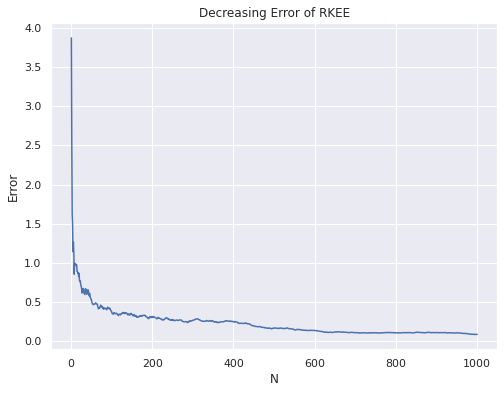

## **Profiling for checking BottleNeck**



In [ ]:
#%lprun -f RKEE RKEE(data)



```
Timer unit: 1e-06 s

**Total time: 22.1974 s**
File: <ipython-input-42-dca9a783d75b>
Function: RKEE at line 1


Line #      Hits         Time  Per Hit   % Time  Line Contents
```

---------------------------------------------------------------------

     1                                           def RKEE(data):
     2                                             """
     3                                             data : [p,n,n]
     4                                             Returns :
     5                                             -------------
     6                                             Karcher mean wrt to GL invariant metric
     7                                             """
     8                                           
     9         1         62.0     62.0      0.0    M_current = data[0]
    10         1          2.0      2.0      0.0    list_of_means = [M_current]
    11      1000       1307.0      1.3      0.0    for k in range(1,data.shape[0]):
    12       999       2853.0      2.9      0.0      X_k       = data[k]
    13       999    7079544.0   7086.6     31.9      M_hf      = fractional_matrix_power(M_current,0.5)
    14       999    7126669.0   7133.8     32.1      M_nhf     = fractional_matrix_power(M_current,-0.5)
    15       999      15506.0     15.5      0.1      temp      = M_nhf @ X_k @ M_nhf
    16       999    7952443.0   7960.4     35.8      temp_pow  = fractional_matrix_power(temp,1/k)
    17       999      16745.0     16.8      0.1      M_current = M_hf @ temp_pow @ M_hf
    18       999       2306.0      2.3      0.0      list_of_means.append(M_current)
    19                                           
    20         1          2.0      2.0      0.0    return list_of_means,M_current

## **First Optimization : computation of powers using diagonalization**


As can be seen most of the time is spent at computing fractional powers. To speed up,  computation of power is done by diagonlization, as SPD matrices are inddeed diagonalizable this is valid. 

$$\text{X} = UDU^{T} \implies X^{a} = UD^{a}U^{T} $$ 


In [ ]:
def frac_pow_egdec(mat,pow):
  e_val , e_vec  = gs.linalg.eigh(mat)
  e_val_pow      = e_val ** pow
  diag           = np.diag(e_val_pow)
  pow            =  e_vec @ diag @ e_vec.T
  return pow

In [ ]:
def RKEE_opt1(data):
  """
  data : [p,n,n]
  Returns :
  -------------
  Karcher mean wrt to GL invariant metric
  """

  M_current = data[0]
  list_of_means = [M_current]
  for k in tqdm(range(1,data.shape[0])):
    X_k       = data[k]
    M_hf      = frac_pow_egdec(M_current,0.5)
    M_nhf     = frac_pow_egdec(M_current,-0.5)
    temp      = M_nhf @ X_k @ M_nhf
    temp_pow  = frac_pow_egdec(temp,1/(k+1))
    M_current = M_hf @ temp_pow @ M_hf
    list_of_means.append(M_current)

  return list_of_means,M_current


In [ ]:
list_of_means,M_current = RKEE_opt1(data)
error = geomstats_GL_inv_distance(M_current,mean)
print(M_current)
print("error : ", error)


[[ 3.08091181  0.08414157 -0.0883799  -0.01350018  0.00379572]
 [ 0.08414157  3.01611849 -0.02217294  0.05631454  0.04799615]
 [-0.0883799  -0.02217294  2.9665707  -0.01986321  0.10133529]
 [-0.01350018  0.05631454 -0.01986321  2.97960295 -0.06806812]
 [ 0.00379572  0.04799615  0.10133529 -0.06806812  3.01718045]]
error :  0.09462152784150732


In [ ]:
#%lprun -f RKEE_opt1 RKEE_opt1(data)



```
Timer unit: 1e-06 s

Total time: 0.205232 s
File: <ipython-input-113-e9df60f3c43e>
Function: RKEE_opt1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
```
-----------------------------------------------------------------------
     1                                           def RKEE_opt1(data):
     2                                             """
     3                                             data : [p,n,n]
     4                                             Returns :
     5                                             -------------
     6                                             Karcher mean wrt to GL invariant metric
     7                                             """
     8                                           
     9         1         79.0     79.0      0.0    M_current = data[0]
    10         1          2.0      2.0      0.0    list_of_means = [M_current]
    11      1000        697.0      0.7      0.3    for k in range(1,data.shape[0]):
    12       999       1155.0      1.2      0.6      X_k       = data[k]
    13       999      65571.0     65.6     31.9      M_hf      = frac_pow_egdec(M_current,0.5)
    14       999      64162.0     64.2     31.3      M_nhf     = frac_pow_egdec(M_current,-0.5)
    15       999       4749.0      4.8      2.3      temp      = M_nhf @ X_k @ M_nhf
    16       999      63153.0     63.2     30.8      temp_pow  = frac_pow_egdec(temp,1/k)
    17       999       4744.0      4.7      2.3      M_current = M_hf @ temp_pow @ M_hf
    18       999        919.0      0.9      0.4      list_of_means.append(M_current)
    19                                           
    20         1          1.0      1.0      0.0    return list_of_means,M_current

# **Second optimization : Batch Computation of powers**

We can improve performance further by using observation that $M^{\frac{1}{2}}$ and $M^{-\frac{1}{2}}$ can be computed jointly because the matrix eigendecomposition will be same and hence we can compute it only once and carryout  the rest of computation exactly same. Note that `scipy`, `numpy` or `geomstats` don't provide such  kind of function. 

In [ ]:
def batch_frac_pow_egdec(mat,pows):
  e_val , e_vec  = gs.linalg.eigh(mat)
  powers = []
  for p in pows:
    e_val_pow = e_val ** p
    diag      = np.diag(e_val_pow)
    power       =  e_vec @ diag @ e_vec.T
    powers.append(power)
  return powers  

In [ ]:
def RKEE_opt2(data):
  """
  data : [p,n,n]
  Returns :
  -------------
  Karcher mean wrt to GL invariant metric
  """

  M_current = data[0]
  list_of_means = [M_current]
  for k in tqdm(range(1,data.shape[0])):
    X_k             = data[k]
    M_hf,M_nhf      = batch_frac_pow_egdec(M_current,[0.5,-0.5])
    temp            = M_nhf @ X_k @ M_nhf
    temp_pow        = batch_frac_pow_egdec(temp,[1/(k+1)])[0]
    M_current       = M_hf @ temp_pow @ M_hf
    list_of_means.append(M_current)

  return list_of_means,M_current


In [ ]:
list_of_means,M_current = RKEE_opt2(data)
error = geomstats_GL_inv_distance(M_current,mean)
print(M_current)
print("error : ", error)


[[ 3.08091181  0.08414157 -0.0883799  -0.01350018  0.00379572]
 [ 0.08414157  3.01611849 -0.02217294  0.05631454  0.04799615]
 [-0.0883799  -0.02217294  2.9665707  -0.01986321  0.10133529]
 [-0.01350018  0.05631454 -0.01986321  2.97960295 -0.06806812]
 [ 0.00379572  0.04799615  0.10133529 -0.06806812  3.01718045]]
error :  0.09462152784150732


In [ ]:
#%lprun -f RKEE_opt2 RKEE_opt2(data)




```

Timer unit: 1e-06 s

Total time: 0.154766 s
File: <ipython-input-116-bc1ce2a4e206>
Function: RKEE_opt2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
```
---------------------------------------------------------------------
     1                                           def RKEE_opt2(data):
     2                                             """
     3                                             data : [p,n,n]
     4                                             Returns :
     5                                             -------------
     6                                             Karcher mean wrt to GL invariant metric
     7                                             """
     8                                           
     9         1          8.0      8.0      0.0    M_current = data[0]
    10         1          1.0      1.0      0.0    list_of_means = [M_current]
    11      1000        717.0      0.7      0.5    for k in range(1,data.shape[0]):
    12       999       1096.0      1.1      0.7      X_k             = data[k]
    13       999      76836.0     76.9     49.6      M_hf,M_nhf      = batch_frac_pow_egdec(M_current,[0.5,-0.5])
    14       999       4844.0      4.8      3.1      temp            = M_nhf @ X_k @ M_nhf
    15       999      65463.0     65.5     42.3      temp_pow        = frac_pow_egdec(temp,1/k)
    16       999       4840.0      4.8      3.1      M_current       = M_hf @ temp_pow @ M_hf
    17       999        961.0      1.0      0.6      list_of_means.append(M_current)
    18                                           
    19         1          0.0      0.0      0.0    return list_of_means,M_current

As can be seen for **n=1000**

Time for RKEE      : **22.1974 s**

Time for RKEE_opt1 : **0.205232 s**

Time for RKEE_opt2 : **0.154766 s**

Hence the Improvement achieved is **108X**  with first optimization and with second optimization **144X**.


###**Efficient GL invariant metric computation**.
We will see how to compute GL invarint metric efficiently than the current implementation in geomstats. Using $\log(X^{-1}Y) = -\log(X) + \log(Y)$ and efficient `einsum` manipulation, improvement of **3X** is obtained in the case of batch of SPD matrices.

In [ ]:
def efficient_GL_invariant_metric(spd_1,spd_2):
  """
    spd_1 : np array
    spd_2 : np array
  """

  log_prod = logm(spd_2)-logm(spd_1)
  if log_prod.ndim == 2:
    dist     =  np.einsum('ij,ji->', log_prod, log_prod)
  elif log_prod.ndim == 3:
    dist     =  np.einsum('ijk,ikj->i', log_prod, log_prod) 
  return dist**0.5

In [ ]:
array_of_means = np.array(list_of_means)
error = efficient_GL_invariant_metric(array_of_means,mean)

In [ ]:
#%lprun -f geomstats_GL_inv_distance geomstats_GL_inv_distance(array_of_means,mean)




```
Timer unit: 1e-06 s

**Total time: 0.050442 s**
File: <ipython-input-34-3a85b589b24d>
Function: geomstats_GL_inv_distance at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents

```



--------------------------------------------------------------------
     1                                           def geomstats_GL_inv_distance(mat1,mat2):
     2         1          8.0      8.0      0.0    n = mat2.shape[-1]
     3         1        152.0    152.0      0.3    metric = SPDMetricAffine(n)
     4         1      50280.0  50280.0     99.7    dist = metric.dist(mat1,mat2)
     5         1          2.0      2.0      0.0    return dist

In [ ]:
#%lprun -f efficient_GL_invariant_metric efficient_GL_invariant_metric(array_of_means,mean)



```

Timer unit: 1e-06 s

**Total time: 0.015065 s**
File: <ipython-input-71-e6ec48a9b612>
Function: efficient_GL_invariant_metric at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents

```

---------------------------------------------------------------------
     1                                           def efficient_GL_invariant_metric(spd_1,spd_2):
     2                                             """
     3                                               spd_1 : np array
     4                                               spd_2 : np array
     5                                             """
     6                                           
     7         1      14984.0  14984.0     99.5    log_prod = logm(spd_2)-logm(spd_1)
     8         1          2.0      2.0      0.0    if log_prod.ndim == 2:
     9                                               dist     =  np.einsum('ij,ji->', log_prod, log_prod)
    10         1          1.0      1.0      0.0    elif log_prod.ndim == 3:
    11         1         70.0     70.0      0.5      dist     =  np.einsum('ijk,ikj->i', log_prod, log_prod) 
    12         1          8.0      8.0      0.1    return dist**0.5

Time for geomstats GL-invariant metric implementation :  0.050442 s

Time for Efficient Implementation suggested : 0.015065 s

Improvement : **3.3X**

#**Mean of Million  Matrices in Minutes**


Following table shows runtime for computintg mean of **MILLION** SPD matrices for different sizes and for different  code optimizations done.

| Size of SPD matrix      | Size of Data | Time for RKEE_opt1 | Time for RKEE_opt2     | Error wrt True mean
| :---:       |     :----: |    :----:   |          :---: |           :---: |
| 3x3      | 72 MB |1 min 32 sec       | **1 min 21 sec**  | 0.00192192
| 5x5      |0.2 GB |1 min 52 sec        | **1 min 29 sec**      | 0.00280658|
| 10x10    |0.8 GB |6 min 01 sec        | **4 min 28 sec**      | 0.00501725|
| 15x15    |1.8 GB  |9 min 46 sec        | **6 min 57 sec**      | 0.00625861

## **Comparision with Gradient Based Algorithms**

In this section we will compare with Gradient Based Algorithms for computation of Frechet mean that is already present in `geomstats`. Geomstats contains following types of gradient based algorithms, but two of them didn't work correctly. So, In ablation study we only consider **default** Gradient Descent is used.



*   Gradient Descent
*   Adaptive Gradient Descent (didn't work, returning right-away without peforming iterations)
*   Ball Gradient Descent (didn't work, started throwing **LinAlgError: Eigenvalues did not converge** seems Implementation is not Stable)

In [ ]:
def gradient_mean(data,method='default'):
  n = data.shape[-1]
  print("shape" , n)
  metric = SPDMetricAffine(n)
  mean_estimator = FrechetMean(metric=metric,method=method,max_iter=3,point_type='matrix',epsilon=1e-12,verbose=1)
  mean_estimator.fit(data)
  mean = mean_estimator.estimate_
  return mean

Following table compares time for Single Iteration of GD for computing mean of **MILLION** of SPD matrices and Error achieved in Same time as RKEE. For 15x15, Gradient Descent Crashed requiring too much RAM (Note that  RKEE succeeded in same RAM  ). Note that for 10x10 case, single iteration for GD nearly takes 2min, whereas for RKEE just takes  $4\frac{1}{2} $ for whole process and there is couple of orders of magintude difference in error achieved (0.00625861 for RKEE and 0.905104629 for GD )

| Size of SPD matrix      | Time for single iteration of GD | Error achieved in Same time as RKEE | 
| :---:       |     :----: |  :----: |   
| 3x3      | 9 Sec | 0.00170370(10 iterations were run)
| 5x5      |25 Sec | 0.003829328(6 iterations were run)
| 10x10    | 1 min 57 sec| 0.905104629 (3 iterations were run)
| 15x15    |CRASHED (requiring too much RAM)  | NA

Building **Efficient K-means**(for GL-invariant metric) with Recursive Karcher Expectation Estimator.

With RKEE, we can efficintely update (add and remove) the mean

broad idea of **Efficient-K-means:**


*   Let there be K clusters
*   Let there $X_i$ be points in ith iteration whose clusters have changed
*   for $x_i \in X_i$:

$\hspace{1cm} \text{Let S be previous cluster of }  x_i$

$\hspace{1cm} \text{Let T be current cluster of }   x_i$

$\hspace{1cm} \text{new mean of S} = \text{SUBTRACT}\text{(current mean of S,x_i)}  $

$\hspace{1cm} \text{new mean of T} = \text{ADD}\text{(current mean of T, x_i)}$











In [ ]:
def add (M, X, k):
  M_hf      = fractional_matrix_power(M,0.5)
  M_nhf     = fractional_matrix_power(M,-0.5)
  temp      = M_nhf @ X @ M_nhf
  temp_pow  = fractional_matrix_power(temp,1/(k+1))
  M_current = M_hf @ temp_pow @ M_hf
  return M_current

In [ ]:
def subtract(M, X, k):
  M_hf      = fractional_matrix_power(M,0.5)
  M_nhf     = fractional_matrix_power(M,-0.5)
  temp      = M_nhf @ X @ M_nhf
  temp_pow  = fractional_matrix_power(temp,-1/(k-1))
  M_current = M_hf @ temp_pow @ M_hf
  return M_current


In [ ]:
def generate_data(means,samples_per_mean):
  """
  means    : [N,n,n]
  ----------------
  Returns  :

  """
  n = means.shape[1]
  p = (int)((n*(n+1))/2)
  cov = np.eye(p)/p
  total_data = []
  labels = []
  for i,mean in enumerate(means):
    data = log_normal_sampling(mean,cov,samples_per_mean)
    total_data.append(data)
    labels.append(np.array([i] * samples_per_mean ))
  total_data = np.vstack(total_data)
  labels = np.hstack(labels)
  return total_data,labels

In [ ]:
def get_data(dim=5,num_clusters=7,samples_per_mean=200):
  base = np.eye(dim)
  mul  = np.random.uniform(0,3*num_clusters,num_clusters)
  cluster_centers = np.array([m*base for m in mul ])
  data,labels = generate_data(cluster_centers,samples_per_mean)
  idx = np.random.permutation(len(data))
  x,y = data[idx], labels[idx]
  return x,y,cluster_centers


In [ ]:
"""EfficientK-means clustering adapted from https://github.com/geomstats/geomstats/blob/master/geomstats/learning/kmeans.py"""

import logging
from random import randint
from sklearn.base import BaseEstimator, ClusterMixin
import geomstats.backend as gs
from geomstats.learning._template import TransformerMixin
from geomstats.learning.frechet_mean import FrechetMean


class EfficientKMeans(TransformerMixin, ClusterMixin, BaseEstimator):
    """Class for k-means clustering on manifolds.
    K-means algorithm using Riemannian manifolds.
    Parameters
    ----------
    n_clusters : int
        Number of clusters (k value of the k-means).
        Optional, default: 8.
    init : str
        How to initialize centroids at the beginning of the algorithm. The
        choice 'random' will select training points as initial centroids
        uniformly at random.
        Optional, default: 'random'.
    tol : float
        Convergence factor. Convergence is achieved when the difference of mean
        distance between two steps is lower than tol.
        Optional, default: 1e-2.
    verbose : int
        If verbose > 0, information will be printed during learning.
        Optional, default: 0.
    """

    def __init__(self, metric, n_clusters=8, init='random',tol=1e-2, verbose=0):
        self.n_clusters = n_clusters
        self.init = init
        self.metric = metric
        self.tol = tol
        self.verbose = verbose

        self.centroids = None
        self.belongs   = None

    def fit(self, X, max_iter=100):
        """Provide clusters centroids and data labels.
        Alternate between computing the mean of each cluster
        and labelling data according to the new positions of the centroids.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Training data, where n_samples is the number of samples and
            n_features is the number of features.
        max_iter : int
            Maximum number of iterations.
            Optional, default: 100.
        Returns
        -------
        self : array-like, shape=[n_clusters,]
            Centroids.
        """
        n_samples = X.shape[0]
        self.centroids = [gs.expand_dims(X[randint(0, n_samples - 1)], 0)
                          for i in range(self.n_clusters)]
        self.centroids = gs.concatenate(self.centroids, axis=0)
        index = 0

        while index < max_iter:
            
            index += 1
            dists = [gs.to_ndarray(
                     self.metric.dist(self.centroids[i], X), 2, 1)
                     for i in range(self.n_clusters)]
            dists = gs.hstack(dists)
            belongs = gs.argmin(dists, 1)
            if (index > 1):
                old_belongs  = gs.copy(self.belongs)
                self.belongs = belongs
            old_centroids = gs.copy(self.centroids)
            for i in range(self.n_clusters):
                fold = gs.squeeze(X[belongs == i])
                if len(fold) > 0:

                    if (index == 1) :
                        self.centroids[i] = self.compute_mean(fold)
                        self.belongs = belongs
                        
                    else :
                        old = old_belongs == i
                        new = self.belongs == i
                        previous_total = np.sum(old)
                        add =  X[ np.logical_and(new,np.invert(old)) ]
                        sub =  X[ np.logical_and(old,np.invert(new)) ]
                        self.centroids[i] = self.update_centroid(old_centroids[i],add,sub,previous_total)

                else:
                    self.centroids[i] = X[randint(0, n_samples - 1)]

            centroids_distances = self.metric.dist(
                old_centroids, self.centroids)

            if gs.mean(centroids_distances) < self.tol:
                if self.verbose > 0:
                    logging.info('Convergence reached after {} '
                                 'iterations'.format(index))

                if self.n_clusters == 1:
                    self.centroids = gs.squeeze(self.centroids, axis=0)

                return gs.copy(self.centroids)

        if index == max_iter:
            logging.warning('K-means maximum number of iterations {} reached. '
                            'The mean may be inaccurate'.format(max_iter))

        if self.n_clusters == 1:
            self.centroids = gs.squeeze(self.centroids, axis=0)
        return gs.copy(self.centroids)

    def update(self,mean,point,weight):
        """
        mean    : mean of some points
        point   : new point
        weight  : weight 
            depending upon the weight (add or removes) point to the mean 
        """

          
        

        M_hf,M_nhf      = batch_frac_pow_egdec(mean,[0.5,-0.5])
        temp            = M_nhf @ point @ M_nhf
        temp_pow        = batch_frac_pow_egdec(temp,[weight])[0]
        M_current       = M_hf @ temp_pow @ M_hf
        return M_current

 
    def compute_mean(self,X):
        """
        X : [N,n,n]
        Returns:
        -------
        mean:[n,n]
        """
        M_current = X[0]
        for k in range(1,X.shape[0]):
          M_current = self.update(M_current,X[k],1/(k+1))
        return M_current


    def update_centroid(self,current_centroid,add,sub,curr_N):
        """
        current_centroid : centroid [n,n]
        add  : points to be added [a,n,n]
        sub  : points to be subtracted [s,n,n]
        curr_N : number of points that were used to compute current_centroid
        """    
        

        for point in add:
            weight = 1/(curr_N+1)
            current_centroid = self.update(current_centroid,point,weight)
            curr_N = curr_N + 1


        for point in sub:
            weight = -1/(curr_N-1)
            current_centroid = self.update(current_centroid,point,weight)
            curr_N = curr_N - 1    
        return current_centroid

    def predict(self, X):
        """Predict the labels for each data point.
        Label each data point with the cluster having the nearest
        centroid using metric distance.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Input data.
        Returns
        -------
        self : array-like, shape=[...,]
            Array of predicted cluster indices for each sample.
        """
        if self.centroids is None:
            raise RuntimeError('fit needs to be called first.')
        dists = gs.stack(
            [self.metric.dist(centroid, X)
             for centroid in self.centroids],
            axis=1)
        dists = gs.squeeze(dists)
        belongs = gs.argmin(dists, -1)
        return belongs

In [ ]:
#RiemannianKmean clustering adapted from https://github.com/geomstats/geomstats/blob/master/geomstats/learning/kmeans.py 
#(to use latest version of K-means)



class RiemannianKMeans(TransformerMixin, ClusterMixin, BaseEstimator):
    """Class for k-means clustering on manifolds.
    K-means algorithm using Riemannian manifolds.
    Parameters
    ----------
    n_clusters : int
        Number of clusters (k value of the k-means).
        Optional, default: 8.
    metric : object of class RiemannianMetric
        The geomstats Riemmanian metric associate to the space used.
    init : str
        How to initialize centroids at the beginning of the algorithm. The
        choice 'random' will select training points as initial centroids
        uniformly at random.
        Optional, default: 'random'.
    tol : float
        Convergence factor. Convergence is achieved when the difference of mean
        distance between two steps is lower than tol.
        Optional, default: 1e-2.
    verbose : int
        If verbose > 0, information will be printed during learning.
        Optional, default: 0.
    Example
    -------
    Available example on the Poincaré Ball and Hypersphere manifolds
    :mod:`examples.plot_kmeans_manifolds`
    """

    def __init__(
            self, metric, n_clusters=8, init='random', lr=5e-3,
            tol=1e-2, mean_method='default', verbose=0, point_type='vector'):
        self.n_clusters = n_clusters
        self.init = init
        self.metric = metric
        self.tol = tol
        self.lr = lr
        self.verbose = verbose
        self.mean_method = mean_method
        self.point_type = point_type

        self.centroids = None

    def fit(self, X, max_iter=100):
        """Provide clusters centroids and data labels.
        Alternate between computing the mean of each cluster
        and labelling data according to the new positions of the centroids.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Training data, where n_samples is the number of samples and
            n_features is the number of features.
        max_iter : int
            Maximum number of iterations.
            Optional, default: 100.
        Returns
        -------
        self : array-like, shape=[n_clusters,]
            Centroids.
        """
        n_samples = X.shape[0]
        self.centroids = [gs.expand_dims(X[randint(0, n_samples - 1)], 0)
                          for i in range(self.n_clusters)]
        self.centroids = gs.concatenate(self.centroids, axis=0)
        index = 0
        while index < max_iter:
            index += 1

            dists = [gs.to_ndarray(
                     self.metric.dist(self.centroids[i], X), 2, 1)
                     for i in range(self.n_clusters)]
            dists = gs.hstack(dists)
            belongs = gs.argmin(dists, 1)
            old_centroids = gs.copy(self.centroids)
            for i in range(self.n_clusters):
                fold = gs.squeeze(X[belongs == i])
                

                if len(fold) > 0:

                    mean = FrechetMean(
                        metric=self.metric,
                        method=self.mean_method,
                        max_iter=150,
                        lr=self.lr,
                        point_type=self.point_type)
                    mean.fit(fold)

                    self.centroids[i] = mean.estimate_
                else:
                    self.centroids[i] = X[randint(0, n_samples - 1)]

            centroids_distances = self.metric.dist(
                old_centroids, self.centroids)

            if gs.mean(centroids_distances) < self.tol:
                if self.verbose > 0:
                    logging.info('Convergence reached after {} '
                                 'iterations'.format(index))

                if self.n_clusters == 1:
                    self.centroids = gs.squeeze(self.centroids, axis=0)

                return gs.copy(self.centroids)

        if index == max_iter:
            logging.warning('K-means maximum number of iterations {} reached. '
                            'The mean may be inaccurate'.format(max_iter))

        if self.n_clusters == 1:
            self.centroids = gs.squeeze(self.centroids, axis=0)
        return gs.copy(self.centroids)

    def predict(self, X):
        """Predict the labels for each data point.
        Label each data point with the cluster having the nearest
        centroid using metric distance.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Input data.
        Returns
        -------
        self : array-like, shape=[...,]
            Array of predicted cluster indices for each sample.
        """
        if self.centroids is None:
            raise RuntimeError('fit needs to be called first.')
        dists = gs.stack(
            [self.metric.dist(centroid, X)
             for centroid in self.centroids],
            axis=1)
        dists = gs.squeeze(dists)

        belongs = gs.argmin(dists, -1)

        return belongs

In [ ]:
def get_error(true,pred,metric):
  dist = metric.dist(true,pred)
  error = gs.mean(dist)
  return error

In [ ]:
X,y,cluster_centers = get_data(num_clusters = 4,samples_per_mean=1000)
true_centers = cluster_centers[y]
n = X.shape[1]
print("data" , X.shape)
print("labels" , y.shape)
metric = SPDMetricAffine(n)


data (4000, 5, 5)
labels (4000,)


In [ ]:
kmeans = RiemannianKMeans(metric, 4, tol=1e-2 ,point_type='matrix' , verbose=1)
kmeans.fit(X)
pred_labels  = kmeans.predict(X)
centroids = kmeans.centroids
pred_centers = centroids[pred_labels]
error = get_error(true_centers,pred_centers,metric)
print("ERROR is ", error)

INFO: Convergence reached after 6 iterations


ERROR is  0.04188951950715958


In [ ]:
kmeans = EfficientKMeans(metric, 4, tol=1e-2,verbose=1)
kmeans.fit(X)
pred_labels  = kmeans.predict(X)
centroids = kmeans.centroids
pred_centers = centroids[pred_labels]
error = get_error(true_centers,pred_centers,metric)
print("ERROR is ", error)

INFO: Convergence reached after 3 iterations


ERROR is  0.042078869388441145


In [ ]:
# %lprun -f kmeans.fit kmeans.fit(X)

In [ ]:
def add (M, X, k):
  M_hf      = fractional_matrix_power(M,0.5)
  M_nhf     = fractional_matrix_power(M,-0.5)
  temp      = M_nhf @ X @ M_nhf
  temp_pow  = fractional_matrix_power(temp,1/(k+1))
  M_current = M_hf @ temp_pow @ M_hf
  return M_current

In [ ]:
def subtract(M, X, k):
  M_hf      = fractional_matrix_power(M,0.5)
  M_nhf     = fractional_matrix_power(M,-0.5)
  temp      = M_nhf @ X @ M_nhf
  temp_pow  = fractional_matrix_power(temp,-1/(k-1))
  M_current = M_hf @ temp_pow @ M_hf
  return M_current


## **Proposed Features of Geomstats**:


1.   4 Dimensional matrix logarithm `log` , matrix exponential  `exp` functions

2.   `log-normal` distribution sampler on Space of SPD matrices

3.   Efficient way for computing `GL-invariant` metric 

4.   `Recursive Estimator` for Mean of SPD matrices under GL-invariant metric

5.   Efficient `Online K-means` Algorithm that based on RKEE


7.    `MSRAction3D dataset` is around 5MB in zipped version. This could be another dataset that can be natively supported in Geomstats

## **References**

(1) [Schwartzman, A. (2016), ‘Lognormal distributions and geometric averages of symmetric
positive definite matrices’](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5222531/#:~:text=Analogously%2C%20a%20random%20symmetric%20positive,%2Dmatrix%2Dvariate%20lognormal%20distribution.)

(2) [Recursive Karcher Expectation Estimators And Geometric Law of
Large Numbers](http://proceedings.mlr.press/v31/ho13a.pdf)

(4) [Action recognition based on a bag of 3D points](https://ieeexplore.ieee.org/document/5543273)

(3) [Human Action Recognition Using a Temporal Hierarchy
of Covariance Descriptors on 3D Joint Locations](http://eng.staff.alexu.edu.eg/~mtorki/Publications/IJCAI13Hussein.pdf)



